In [14]:
import numpy as np
import random
import tensorflow.compat.v1 as tf

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_random_seed(seed)

set_seeds(100)

# Building a Financial Environment

The "gym" environments provided by OpenAI are a convenient and standardized way to represent environments for any games we want to train our agents to play. Desiging a financial environment class that operates much like the OpenAI gym environments allows us to train the same DQN algorithms we explored previously on financial data.

In [3]:
import random
import pandas as pd
import numpy as np

class observation_space:
  def __init__(self, n):
    self.shape = (n,)

class action_space:
  def __init__(self, n):
    self.n = n
  def sample(self):
    return random.randint(0, self.n - 1)


class Finance:

  def __init__(self, symbol, features):
    self.symbol = symbol
    self.features = features
    self.observation_space = observation_space(4)
    self.osn = self.observation_space.shape[0]
    self.action_space = action_space(2)
    self.min_accuracy = 0.50 # Similar to cartpole, we consider the game to have "ended" when the accuracy falls below this threshold
    self._get_data()
    self._prepare_data()

  def _get_data(self):
    self.raw = pd.read_csv('data/eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

  def _prepare_data(self):
    self.data = pd.DataFrame(self.raw[self.symbol])
    self.data['r'] = np.log(self.data / self.data.shift(1))
    self.data.dropna(inplace=True)
    self.data_ = (self.data - self.data.mean()) / self.data.std() # data_ is the normalized data
    self.data['d'] = np.where(self.data['r'] > 0, 1, 0)

  def _get_state(self):
    return self.data_[self.features].iloc[self.bar - self.osn:self.bar].values
  
  def seed(self, seed=None):
    pass

  def reset(self):
    self.treward = 0
    self.accuracy = 0
    self.bar = self.osn
    return self._get_state()

  def step(self, action):
    correct = action == self.data['d'].iloc[self.bar]
    reward = 1 if correct else 0
    self.treward += reward
    self.bar += 1
    self.accuracy = self.treward / (self.bar - self.osn)
    if self.bar >= len(self.data):
      done = True
    elif reward == 1:
      done = False
    elif (self.accuracy < self.min_accuracy and self.bar > self.osn + 5):
      done = True
    else:
      done = False
    state = self._get_state()
    info = {}
    return state, reward, done, info


  

# Testing the Environment

In [5]:
sym = 'EUR='
env = Finance(sym, sym)

env.data.head()

,EUR=,r,d
Date,,,
2010-01-05,1.4368,-0.002988,0
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,0
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


Above, we see that the price data and the daily return values are on different orders of magnitude: this can affect the results of training negatively. Normalized data will be used instead for training and prediction, which is available in the `data_` attribute.

In [9]:
# This displays the normalized data (both the price and the return)
env.data_.head()

,EUR=,r
Date,,
2010-01-05,1.819013,-0.512515
2010-01-06,1.857863,0.560271
2010-01-07,1.774864,-1.143381
2010-01-08,1.857863,1.178824
2010-01-11,1.947043,1.256879


In [6]:
env.data[sym].diff().apply(np.sign).value_counts()
# Here we see that there are more or less the same number of ticks where the value goes up as goes down

EUR=
 1.0    1258
-1.0    1243
 0.0      13
Name: count, dtype: int64

We can plot the price trend of EURUSD from 2010 to 2020

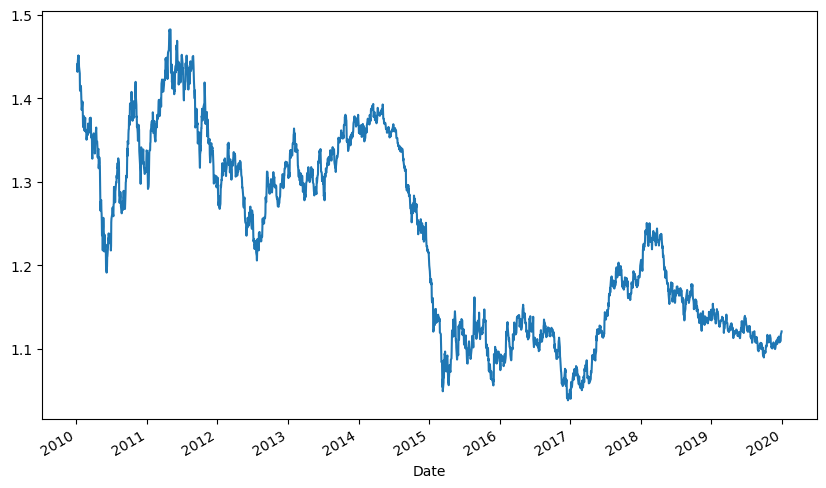

In [7]:
env.data[sym].plot(figsize=(10, 6));

In [10]:
env.reset()
a = env.action_space.sample()
a

1

In [11]:
env.step(a)

(array([1.85786346, 1.77486442, 1.85786346, 1.94704329]), 1, False, {})

In the result of `env.step()` above, 1 represents the reward.

# The Agent

Below I use the same agent that successfully completed the OpenAI Lunar Lander environment.

In [2]:
from keras.layers import Dense, Activation, Input
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np


class ReplayBuffer(object):
  # One can use ReplayBuffer or deque. However ReplayBuffer has some advantages (despite being many more lines of code)
  def __init__(self, max_size, input_shape, n_actions, discrete=False):
    self.mem_size = max_size
    self.discrete = discrete
    self.mem_cntr = 0
    self.state_memory = np.zeros((self.mem_size, input_shape))
    self.new_state_memory = np.zeros((self.mem_size, input_shape))
    self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.int8 if self.discrete else np.float32)
    self.reward_memory = np.zeros(self.mem_size)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      # One hot encoding
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)
    return self.state_memory[batch], self.action_memory[batch], self.reward_memory[batch], self.new_state_memory[batch], self.terminal_memory[batch]


def build_dqn(learning_rate, n_actions, input_dims, fc1_dims, fc2_dims):
  model = Sequential([
      Input(shape=(input_dims,)),
      Dense(fc1_dims),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(n_actions)
  ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
  return model


class Agent(object):
  def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.998, epsilon_end=0.01, mem_size=1000000, fname='models/5_fin_model.keras'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size
    self.model_file = fname

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
    self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

  def remember(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)


  def choose_action(self, state):
    state = state[np.newaxis, :]
    action = np.random.choice(self.action_space) if np.random.random() < self.epsilon else np.argmax(self.q_eval.predict(state, verbose=False))
    return action
  
  def learn(self):
    if self.memory.mem_cntr > self.batch_size:
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size) # Sample non-sequential memories
      action_values = np.array(self.action_space, dtype=np.int8)
      action_indices = np.dot(action, action_values)
      q_next = self.q_eval.predict(new_state, verbose=False)
      q_eval = self.q_eval.predict(state, verbose=False)
      q_target = q_eval.copy()
      batch_index = np.arange(self.batch_size, dtype=np.int32)
      q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis=1) * done
      _ = self.q_eval.fit(state, q_target, verbose=False)
      self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon

  def save_model(self):
    self.q_eval.save(self.model_file)

  def load_model(self):
    self.q_eval = load_model(self.model_file)

2024-06-13 16:55:54.078001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training the Agent

In [31]:
import time  # Import the time module

env = Finance(sym, sym) # In this example, the only feature from the data that we train on is the price of the asset itself
env.reset()
n_episodes = 101

agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=env.observation_space.shape[0], n_actions=env.action_space.n, mem_size=int(1e6), batch_size=64, epsilon_end=0.01, fname='models/5_fin_model_a.keras')

restore_agent = False
if restore_agent:
  agent.load_model() # Use this to re-load the model without needing to retrain

scores = []
eps_history = []
averages = []

for i in range(n_episodes):
  start_time = time.time() 

  observation, score, done = env.reset(), 0, False
  iteration = 0
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward
    agent.remember(observation, action, reward, observation_, int(done))
    observation = observation_
    agent.learn()
    if iteration % 10 == 0:
      print("\rFinished Learning iteration: {}".format(iteration), end="")
    iteration += 1
  print("")
  eps_history.append(agent.epsilon)
  scores.append(score)

  end_time = time.time()  

  averages.append(np.mean(scores[-25:]))
  print(f'Episode: {i}, score: {score:.2f}, moving average: {averages[-1]:.2f}, epsilon: {"{:.2g}".format(agent.epsilon)}, time: {end_time - start_time:.2f}')

  if i % 10 == 0:
    agent.save_model()

Finished Learning iteration: 0
Episode: 0, score: 4.00, moving average: 4.00, epsilon: 1, time: 0.00
Finished Learning iteration: 10
Episode: 1, score: 5.00, moving average: 4.50, epsilon: 1, time: 0.00
Finished Learning iteration: 0
Episode: 2, score: 3.00, moving average: 4.00, epsilon: 1, time: 0.00
Finished Learning iteration: 80
Episode: 3, score: 40.00, moving average: 13.00, epsilon: 0.92, time: 8.14
Finished Learning iteration: 0
Episode: 4, score: 2.00, moving average: 10.80, epsilon: 0.9, time: 0.93
Finished Learning iteration: 0
Episode: 5, score: 4.00, moving average: 9.67, epsilon: 0.89, time: 1.44
Finished Learning iteration: 1730
Episode: 6, score: 868.00, moving average: 132.29, epsilon: 0.027, time: 326.60
Finished Learning iteration: 180
Episode: 7, score: 90.00, moving average: 127.00, epsilon: 0.019, time: 36.64
Finished Learning iteration: 40
Episode: 8, score: 21.00, moving average: 115.22, epsilon: 0.018, time: 8.34
Finished Learning iteration: 340
Episode: 9, sc

In [32]:
agent.epsilon

0.009985630741373389

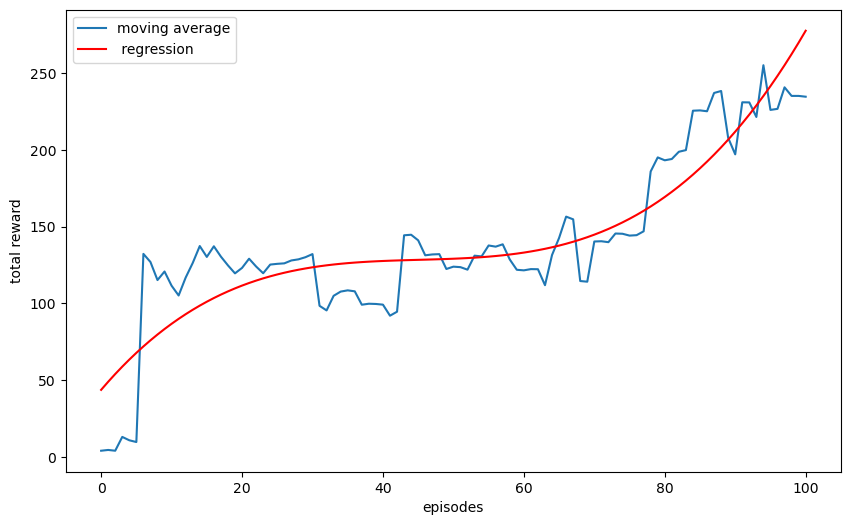

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = range (len (averages))
y = np. polyval(np.polyfit(x, averages, deg=3), x)
plt.plot(averages, label='Moving Average')
plt.plot(x, y, 'r-', label='Regression')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.legend();

Although this agent clearly had the potential to keep improving, it was able to achieve a rolling-average total reward of 235 by the end of 100 episodes of training.

# Trying Different Features

The previous agent was trained on the asset's price itself. Thanks to our `Finance` class, it is simple to repeat the process using the returns data (daily percentage change) to test whether it produces a better result.

In [6]:
import time  # Import the time module

env = Finance(sym, 'r') # In this example, the only feature from the data that we train on is the price of the asset itself
env.reset()
n_episodes = 101

agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=env.observation_space.shape[0], n_actions=env.action_space.n, mem_size=int(1e6), batch_size=64, epsilon_end=0.01, fname='models/5_fin_model_b.keras')

restore_agent = False
if restore_agent:
  agent.load_model() # Use this to re-load the model without needing to retrain

scores = []
eps_history = []
averages = []

for i in range(n_episodes):
  start_time = time.time() 

  observation, score, done = env.reset(), 0, False
  iteration = 0
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward
    agent.remember(observation, action, reward, observation_, int(done))
    observation = observation_
    agent.learn()
    if iteration % 10 == 0:
      print("\rFinished Learning iteration: {}".format(iteration), end="")
    iteration += 1
  print("")
  eps_history.append(agent.epsilon)
  scores.append(score)

  end_time = time.time()  

  averages.append(np.mean(scores[-25:]))
  print(f'Episode: {i}, score: {score:.2f}, moving average: {averages[-1]:.2f}, epsilon: {"{:.2g}".format(agent.epsilon)}, time: {end_time - start_time:.2f}')

  if i % 10 == 0:
    agent.save_model()

2024-06-13 16:56:33.182549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Finished Learning iteration: 0
Episode: 0, score: 3.00, moving average: 3.00, epsilon: 1, time: 0.00
Finished Learning iteration: 0
Episode: 1, score: 4.00, moving average: 3.50, epsilon: 1, time: 0.00
Finished Learning iteration: 10
Episode: 2, score: 7.00, moving average: 4.67, epsilon: 1, time: 0.00
Finished Learning iteration: 10
Episode: 3, score: 6.00, moving average: 5.00, epsilon: 1, time: 0.00
Finished Learning iteration: 0
Episode: 4, score: 4.00, moving average: 4.80, epsilon: 1, time: 0.00
Finished Learning iteration: 10
Episode: 5, score: 7.00, moving average: 5.17, epsilon: 0.99, time: 1.01
Finished Learning iteration: 610
Episode: 6, score: 305.00, moving average: 48.00, epsilon: 0.29, time: 105.18
Finished Learning iteration: 0
Episode: 7, score: 2.00, moving average: 42.25, epsilon: 0.29, time: 1.09
Finished Learning iteration: 50
Episode: 8, score: 26.00, moving average: 40.44, epsilon: 0.26, time: 9.52
Finished Learning iteration: 0
Episode: 9, score: 4.00, moving av

I stopped this calculation early, both to save time and as the moving average score has moved above 1,000 with a high degree of consistency - demonstrating that this agent learns significantly better from the returns data than from the price data directly.

The reason the agent above consistently stops at iteration ~2510 is since there are 252 trading days per year and 10 days of data. This means the agent's win-rate never falls below 50% as it loops over the entire training set. Notice despite this the agent's score still varies somewhat, even when it is managing to loop over the entire dataset.

Given that there are 2511 days of EURUSD data, we can calculate the agent's win rate: From the training logs, the maximum reward was 1480 (with +1 reward given for each correct prediction), this suggests a win rate of approximately 1480/2511 = 59.0% (to 3 s.f.). While this certainly shows that the agent is learning to predict the price's direction successfully (random guesses would result in a ~50% win rate) - it is not necessarily a remarkable result since this is evaluated based on data from the training set.

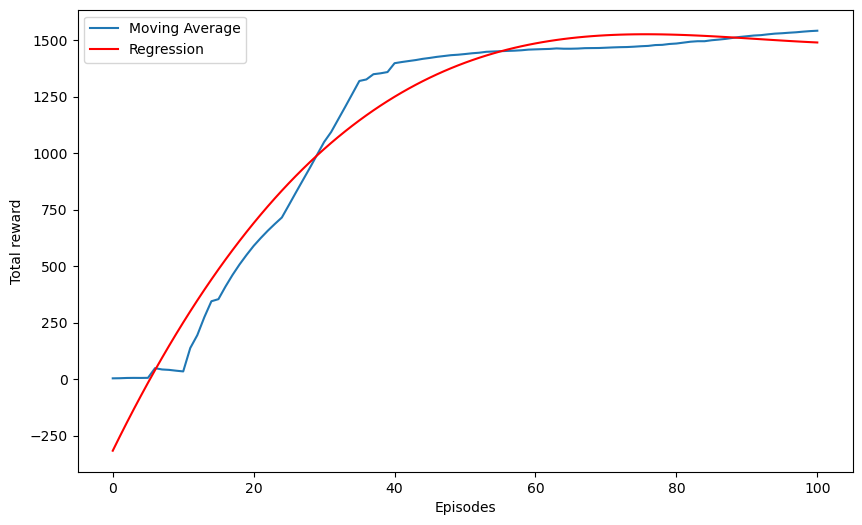

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = range (len (averages))
y = np. polyval(np.polyfit(x, averages, deg=3), x)
plt.plot(averages, label='Moving Average')
plt.plot(x, y, 'r-', label='Regression')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.legend();

The plot above shows the total reward earned by the agent in each episode increasing as the training continues. To better understand if this is learning in a generalizable way, or simply overfitting to the training data would require a validation set.